# Gamma Mixture Model

This notebook implements one of the experiments outlined in https://biaslab.github.io/publication/mp-based-inference-in-gmm/.

## Load packages

In [2]:
using RxInfer
using Distributions, Random
# using StatsPlots

In [3]:
# create custom structure for model parameters for simplicity
struct GammaMixtureModelParameters
    nmixtures   # number of mixtures
    priors_as   # tuple of priors for variable a
    priors_bs   # tuple of priors for variable b
    prior_s     # prior of variable s
end

## Model specification

In [15]:
@model function gamma_mixture_model(nobservations, parameters::GammaMixtureModelParameters)

    # fetch information from struct
    nmixtures = parameters.nmixtures
    priors_as = parameters.priors_as
    priors_bs = parameters.priors_bs
    prior_s   = parameters.prior_s

    # set prior on global selection variable
    s ~ Dirichlet(probvec(prior_s))

    # allocate vectors of random variables
    as = randomvar(nmixtures)
    bs = randomvar(nmixtures)

    # set priors on variables of mixtures
    for i in 1:nmixtures
        as[i] ~ GammaShapeRate(shape(priors_as[i]), rate(priors_as[i]))
        bs[i] ~ GammaShapeRate(shape(priors_bs[i]), rate(priors_bs[i]))
    end

    # introduce random variables for local selection variables and data
    z = randomvar(nobservations)
    y = datavar(Float64, nobservations)

    # convert vector to tuples for proper functioning of GammaMixture node
    tas = tuple(as...)
    tbs = tuple(bs...)

    # specify local selection variable and data generating process
    for i in 1:nobservations
        z[i] ~ Categorical(s) 
        y[i] ~ GammaMixture(z[i], tas, tbs) 
    end

    # return random variables
    return s, as, bs, z, y
    
end

In [10]:
constraints = @constraints begin 
    q(as) :: PointMass(starting_point = (args...) -> [ 1.0 ])
end

Constraints:
  marginals form:
    q(as) :: PointMassFormConstraint() [ prod_constraint = ProdGeneric(fallback = ProdAnalytical()) ]
  messages form:
  factorisation:
Options:
  warn = true


In [28]:
# Alternatively we can use importance sampling as sugessted at https://ieeexplore.ieee.org/document/9596329
using Random

n_samples = 2500
constraints = @constraints begin 
    q(as) :: ImportanceSamplingApproximation(n_samples)
    q(as, bs, z, s) = q(as)q(bs)q(z)q(s)
    q(as) = q(as[begin])..q(as[end])
    q(bs) = q(bs[begin])..q(bs[end])
end

Constraints:
  marginals form:
    q(as) :: ImportanceSamplingApproximation{Float64, Random._GLOBAL_RNG}(Random._GLOBAL_RNG(), 2500, [0.0, 1.9470181400381173e-308, 0.0, NaN, 6.943005389883e-310, 6.953758987035293e-309, 1.53e-322, -3.8195924237e-313, 6.94300538988536e-310, 1.946945992181175e-308  …  6.942958857364e-310, 0.0, 6.94300747216653e-310, 2.2767e-320, 0.0, 6.9430053908628e-310, 6.943005390864e-310, 6.942958857364e-310, 0.0, 6.94300747217246e-310], [0.0, 5.04e-322, 6.94300547662036e-310, NaN, 0.0, NaN, 2.314627943e-314, 1.0e-323, 0.0, NaN  …  5.21501770335773e-310, 5.21501770336445e-310, 6.9429975299966e-310, 3.60739284464e-313, 0.0, 0.0, 5.0e-324, 0.0, NaN, 0.0], true, [0.0, NaN, 0.0, 5.04e-322, 2.315603746e-314, 1.0e-323, 6.943007518835e-310, 0.0, 6.9431702280383e-310, 6.9430079708013e-310  …  1.040026608955e-312, 6.9430054810144e-310, 6.9430054812547e-310, 6.94300537025515e-310, 0.0, 6.94300548104877e-310, 3.1315130625140255e-294, 0.0, 5.21502291763565e-310, 5.21501685587625e

In [29]:
# specify seed and number of data points
rng = MersenneTwister(43)
n_samples = 2500

# specify parameters of mixture model that generates the data
# Note that mixture components have exactly the same means
mixtures  = [ Gamma(9.0, inv(27.0)), Gamma(90.0, inv(270.0)) ]
nmixtures = length(mixtures)
mixing    = rand(rng, nmixtures)
mixing    = mixing ./ sum(mixing)
mixture   = MixtureModel(mixtures, mixing)

# generate data set
dataset = rand(rng, mixture, n_samples);

In [30]:
dataset

2500-element Vector{Float64}:
 0.38155011660408605
 0.30659460839234337
 0.4243427749997887
 0.32733259745853993
 0.2991456581501341
 0.30228584795492497
 0.3361750373903266
 0.34395285705008394
 0.3624888917731254
 0.31686984375473587
 0.44285152740153527
 0.2920158142343281
 0.32589420874803143
 ⋮
 0.3532942950631915
 0.3402449142410333
 0.2685646567328748
 0.34597321390472124
 0.3626777604960055
 0.33283527084287384
 0.2834341199154546
 0.34345915499589463
 0.34077366082658905
 0.3595595485701898
 0.29390735628550746
 0.30150526964391616

In [ ]:
# specify priors of probabilistic model
# NOTE: As the means of the mixtures "collide", we specify informative prior for selector variable
nmixtures = 2
gpriors = GammaMixtureModelParameters(
    nmixtures,                                                    # number of mixtures
    [ GammaShapeRate(1.0, 1.0), GammaShapeRate(1.0, 1.0) ],                         # priors on variables a
    [ GammaShapeRate(10.0, 2.0), GammaShapeRate(1.0, 3.0) ],      # priors on variables b
    Dirichlet(1e3*mixing)                                         # prior on variable s
)

gmodel         = gamma_mixture_model(length(dataset), gpriors)
gdata          = (y = dataset, )
ginitmarginals = (s = gpriors.prior_s, z = vague(Categorical, gpriors.nmixtures), bs = GammaShapeRate(1.0, 1.0))
greturnvars    = (s = KeepLast(), z = KeepLast(), as = KeepEach(), bs = KeepEach())

goptions = (
    limit_stack_depth     = 100,
    
)

gresult = inference(
    model       = gmodel, 
    data        = gdata,
    constraints = constraints,
    # options     = goptions,
    initmarginals = ginitmarginals,
    returnvars    = greturnvars,
    free_energy   = true,
    iterations    = 250, 
    showprogress  = true
);

Progress:   8%|███▏                                     |  ETA: 0:04:02

In [ ]:
# extract inferred parameters
_as, _bs = mean.(gresult.posteriors[:as][end]), mean.(gresult.posteriors[:bs][end])
_dists   = map(g -> Gamma(g[1], inv(g[2])), zip(_as, _bs))
_mixing = mean(gresult.posteriors[:s])

# create model from inferred parameters
_mixture   = MixtureModel(_dists, _mixing);

In [24]:
# report on outcome of inference
println("Generated means: $(mean(mixtures[1])) and $(mean(mixtures[2]))")
println("Inferred means: $(mean(_dists[1])) and $(mean(_dists[2]))")
println("========")
println("Generated mixing: $(mixing)")
println("Inferred mixing: $(_mixing)")

Generated means: 0.3333333333333333 and 0.33333333333333337
Inferred means: 0.3453599914450895 and 0.333366310028031
Generated mixing: [0.18923488676601088, 0.8107651132339891]
Inferred mixing: [0.07854158366785582, 0.9214584163321441]


In [25]:
using StatsPlots

[ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]


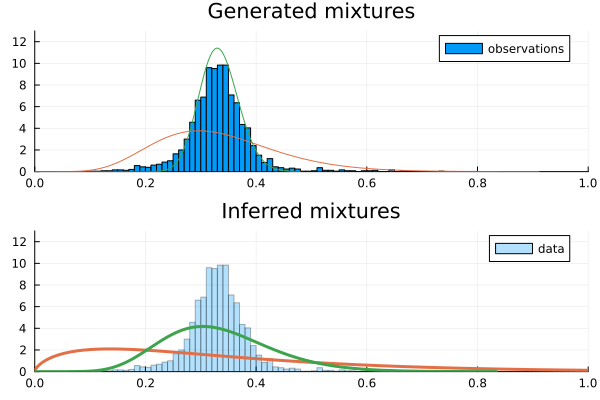

In [26]:
# plot results
p1 = histogram(dataset, ylim = (0, 13), xlim = (0, 1), normalize=:pdf, label="observations")
p1 = plot!(mixture, label=false, title="Generated mixtures")

p2 = histogram(dataset, ylim = (0, 13), xlim = (0, 1), normalize=:pdf, label="data", opacity=0.3)
p2 = plot!(_mixture, label=false, title="Inferred mixtures", linewidth=3.0)

# evaluate the convergence of the algorithm by monitoring the BFE
p3 = plot(gresult.free_energy, label=false, xlabel="iterations", title="Bethe FE")

plot(p1, p2, layout = @layout([ a; b ]))

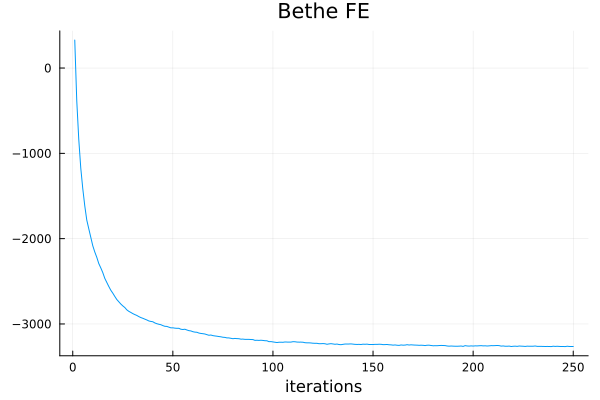

In [60]:
plot(p3)